# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

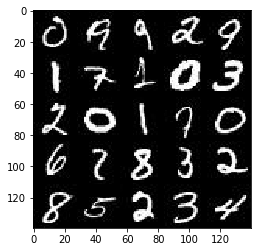

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

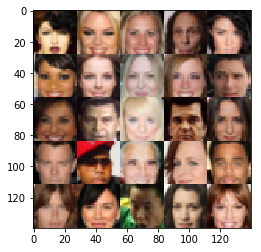

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """  
    
    # Real images dimention
    real_dim = (image_width, image_height, image_channels)
    
    # Real images placeholder
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim))
    
    # Generator input placeholder
    z = tf.placeholder(tf.float32, (None, z_dim))
    
    # Learning rate
    learning_rate = tf.placeholder(tf.float32, shape=())
    
    return inputs_real, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
     
        # First convolutional layer - 14 x 14 x 64
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1r = tf.maximum(alpha * conv1, conv1)
        
        # Second convolutional layer - 7 x 7 x 128
        conv2 = tf.layers.conv2d(conv1r, 128, 5, strides=2, padding='same')
        conv2n = tf.layers.batch_normalization(conv2, training=True)
        conv2r = tf.maximum(alpha * conv2n, conv2n)
        
        # Third convolutional layer - 4 x 4 x 256
        conv3 = tf.layers.conv2d(conv2r, 256, 5, strides=2, padding='same')
        conv3n = tf.layers.batch_normalization(conv3, training=True)
        conv3r = tf.maximum(alpha * conv3n, conv3n)
        
        # Fourth convolutional layer - 2 x 2 x 512
        conv4 = tf.layers.conv2d(conv3r, 512, 5, strides=2, padding='same')
        conv4n = tf.layers.batch_normalization(conv4, training=True)
        conv4r = tf.maximum(alpha * conv4n, conv4n)
                
        # Reshape output for the final layer
        reshape = tf.reshape(conv4r,(-1, 8 * 64 * 2 * 2))
        
        # Logits
        logits = tf.layers.dense(reshape, 1)
        
        # Output
        out = tf.sigmoid(logits)
     

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        
        # Dense layer
        d = tf.layers.dense(z, 16 * 32 * 3 * 3)
        dr = tf.reshape(d, (-1, 3, 3, 16 * 32))
        drn = tf.layers.batch_normalization(dr, training=is_train)
        drnr = tf.maximum(alpha * drn, drn)
        
        # First transpose convolution - 7 x 7 x 128
        c1 = tf.layers.conv2d_transpose(drnr, 128, 3, strides=2, padding='valid')
        c1n = tf.layers.batch_normalization(c1, training=is_train)
        c1nr = tf.maximum(alpha * c1n, c1n)
        
        # Second transpose convolution - 14 x 14 x 64 
        c2 = tf.layers.conv2d_transpose(c1nr, 64, 5, strides=2, padding='same')
        c2n = tf.layers.batch_normalization(c2, training=is_train)
        c2nr = tf.maximum(alpha * c2n, c2n)
        
        # Third transpose convolution - 28 x 28 x 32
        c3 = tf.layers.conv2d_transpose(c2nr, 32, 5, strides=2, padding='same')
        c3n = tf.layers.batch_normalization(c3, training=is_train)
        c3nr = tf.maximum(alpha * c3n, c3n)
        
        # Fourth transpose convolution - 28 x 28 x out_channel_dim
        c4 = tf.layers.conv2d_transpose(c3nr, out_channel_dim, 5, strides=1, padding='same')
        
        # Output
        out = tf.tanh(c4)        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    # Real images from discriminator
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    
    # Fake images from discriminator
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Discriminator real images loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    
    # Discriminator fake images loss
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    # Generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # Discriminator loss
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Trainable variables
    t_vars = tf.trainable_variables()
    
    # Trainable discriminator variables
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # Trainable generator variables
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Generator update
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    # Optimizers
    with tf.control_dependencies(gen_updates):
        
        # Train optimizer for Discriminator
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
        # Train optimizer for Generator
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
    # Number of color channels
    _, image_w, image_h, n_channels = data_shape
    
    # Model input
    img, z, lr = model_inputs(image_w, image_h, n_channels, z_dim)
    
    # Losses
    d_loss, g_loss = model_loss(img, z, n_channels)
    
    # Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            # Set initial steps and sums
            steps = 0
            d_loss_sum = 0
            g_loss_sum = 0
            batch_count = 0
            
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_count += 1
                batch_images * 2
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={img: batch_images, z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z: batch_z, lr: learning_rate})

                # Update loss sums
                d_loss_sum += d_loss.eval({z: batch_z, img: batch_images})
                g_loss_sum += g_loss.eval({z: batch_z})

                # Print the losses
                if steps%20 == 0:
                    
                    # Generator output
                    show_generator_output(sess, 16, z, n_channels, data_image_mode)
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Avg. Discriminator Loss: {:.4f}...".format(d_loss_sum / batch_count),
                          "Avg. Generator Loss: {:.4f}".format(g_loss_sum / batch_count))   
                    
                    # Set loss sums back to zero
                    d_loss_sum = 0
                    g_loss_sum = 0
                    
                    # Set batch count back to zero
                    batch_count = 0
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

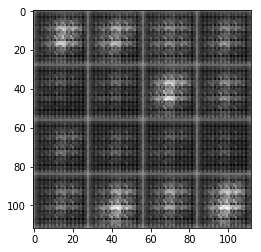

Epoch 1/2... Avg. Discriminator Loss: 3.4007... Avg. Generator Loss: 3.3678


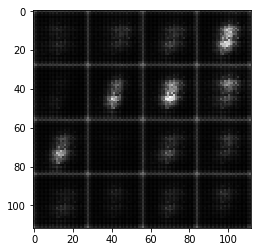

Epoch 1/2... Avg. Discriminator Loss: 1.3669... Avg. Generator Loss: 1.9893


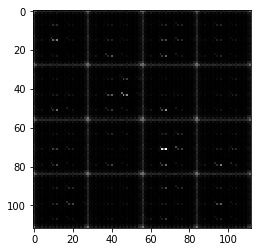

Epoch 1/2... Avg. Discriminator Loss: 0.6878... Avg. Generator Loss: 3.7131


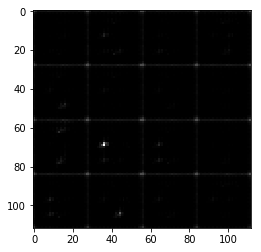

Epoch 1/2... Avg. Discriminator Loss: 0.6831... Avg. Generator Loss: 2.5253


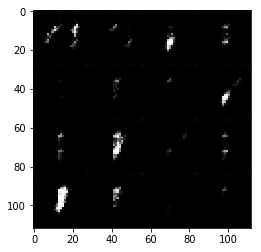

Epoch 1/2... Avg. Discriminator Loss: 1.3993... Avg. Generator Loss: 1.4498


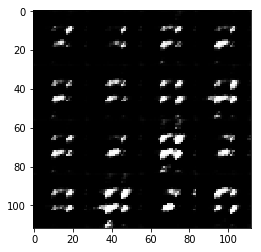

Epoch 1/2... Avg. Discriminator Loss: 1.2050... Avg. Generator Loss: 2.1707


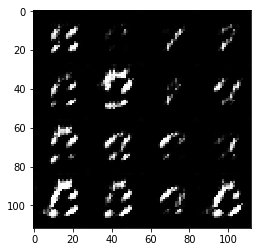

Epoch 1/2... Avg. Discriminator Loss: 0.7487... Avg. Generator Loss: 1.9073


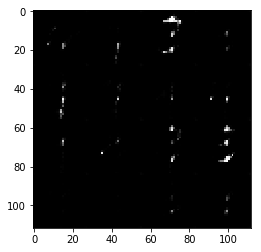

Epoch 1/2... Avg. Discriminator Loss: 1.4217... Avg. Generator Loss: 2.2758


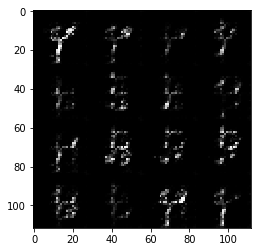

Epoch 1/2... Avg. Discriminator Loss: 0.4363... Avg. Generator Loss: 3.1914


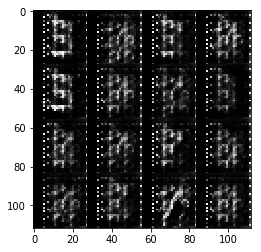

Epoch 1/2... Avg. Discriminator Loss: 0.5785... Avg. Generator Loss: 4.5545


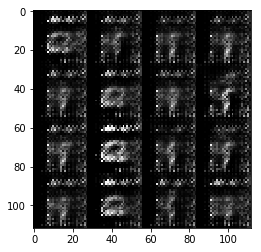

Epoch 1/2... Avg. Discriminator Loss: 0.4071... Avg. Generator Loss: 3.8173


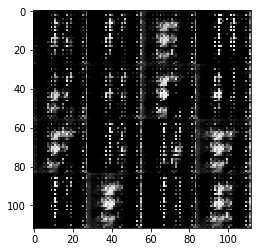

Epoch 1/2... Avg. Discriminator Loss: 1.0025... Avg. Generator Loss: 2.6282


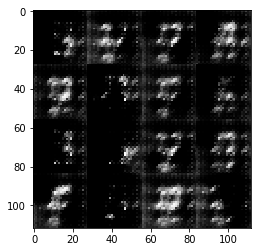

Epoch 1/2... Avg. Discriminator Loss: 1.1157... Avg. Generator Loss: 1.8737


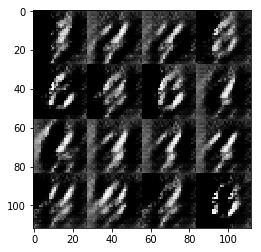

Epoch 1/2... Avg. Discriminator Loss: 1.1332... Avg. Generator Loss: 2.3285


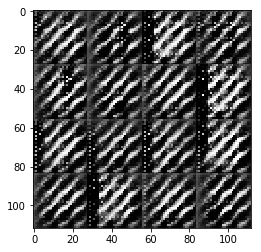

Epoch 1/2... Avg. Discriminator Loss: 0.8245... Avg. Generator Loss: 1.9423


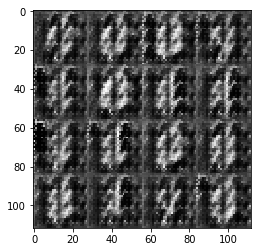

Epoch 1/2... Avg. Discriminator Loss: 0.6760... Avg. Generator Loss: 2.6150


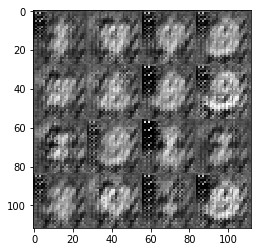

Epoch 1/2... Avg. Discriminator Loss: 0.8269... Avg. Generator Loss: 2.2762


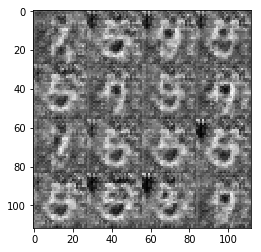

Epoch 1/2... Avg. Discriminator Loss: 0.7262... Avg. Generator Loss: 2.7241


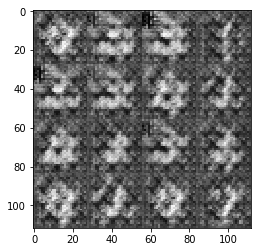

Epoch 1/2... Avg. Discriminator Loss: 0.8978... Avg. Generator Loss: 2.4806


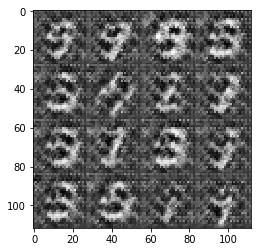

Epoch 1/2... Avg. Discriminator Loss: 0.9770... Avg. Generator Loss: 2.1744


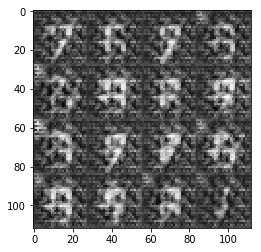

Epoch 1/2... Avg. Discriminator Loss: 0.6340... Avg. Generator Loss: 2.4140


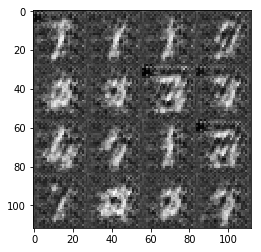

Epoch 1/2... Avg. Discriminator Loss: 0.5141... Avg. Generator Loss: 3.8613


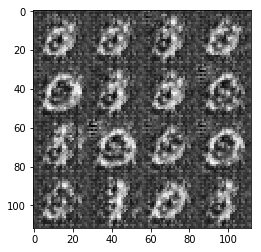

Epoch 1/2... Avg. Discriminator Loss: 0.7041... Avg. Generator Loss: 4.3764


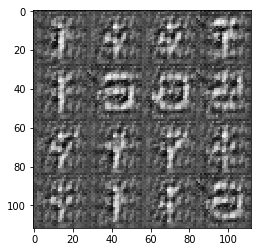

Epoch 1/2... Avg. Discriminator Loss: 0.8000... Avg. Generator Loss: 2.1893


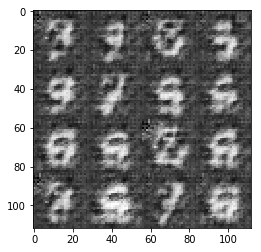

Epoch 1/2... Avg. Discriminator Loss: 1.0336... Avg. Generator Loss: 2.0650


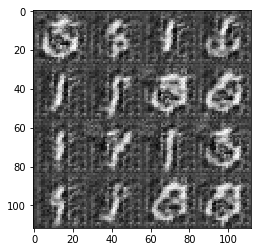

Epoch 1/2... Avg. Discriminator Loss: 0.5033... Avg. Generator Loss: 2.6165


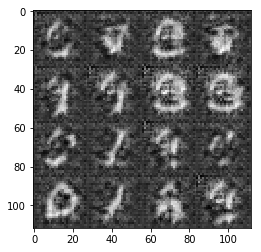

Epoch 1/2... Avg. Discriminator Loss: 1.2277... Avg. Generator Loss: 2.1292


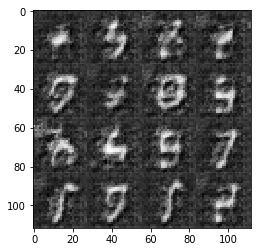

Epoch 1/2... Avg. Discriminator Loss: 0.9822... Avg. Generator Loss: 1.6324


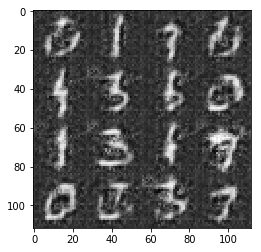

Epoch 1/2... Avg. Discriminator Loss: 0.8050... Avg. Generator Loss: 1.8923


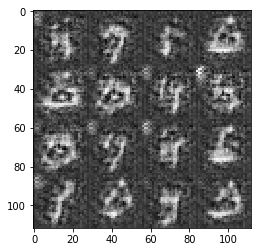

Epoch 1/2... Avg. Discriminator Loss: 0.7757... Avg. Generator Loss: 2.0701


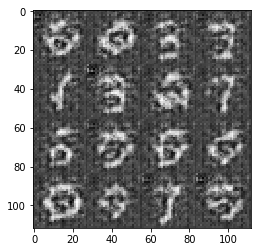

Epoch 1/2... Avg. Discriminator Loss: 0.8412... Avg. Generator Loss: 2.6267


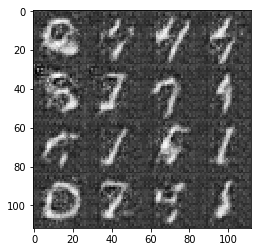

Epoch 1/2... Avg. Discriminator Loss: 1.1139... Avg. Generator Loss: 2.2221


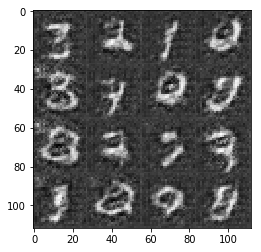

Epoch 1/2... Avg. Discriminator Loss: 0.6259... Avg. Generator Loss: 1.9405


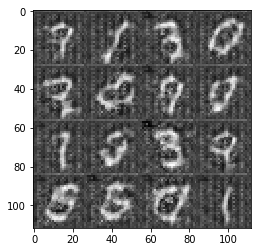

Epoch 1/2... Avg. Discriminator Loss: 1.3275... Avg. Generator Loss: 2.0436


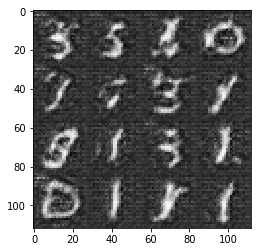

Epoch 1/2... Avg. Discriminator Loss: 1.1423... Avg. Generator Loss: 1.5385


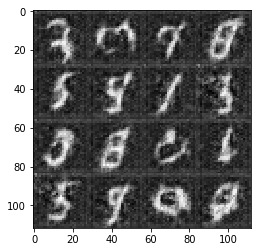

Epoch 1/2... Avg. Discriminator Loss: 1.0064... Avg. Generator Loss: 1.4710


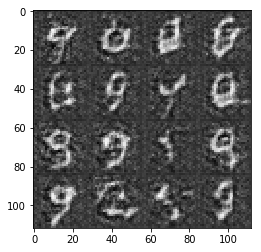

Epoch 1/2... Avg. Discriminator Loss: 0.9269... Avg. Generator Loss: 1.7750


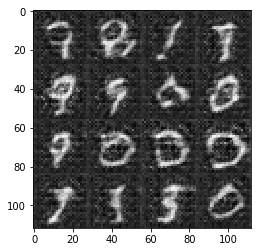

Epoch 1/2... Avg. Discriminator Loss: 1.0104... Avg. Generator Loss: 1.9861


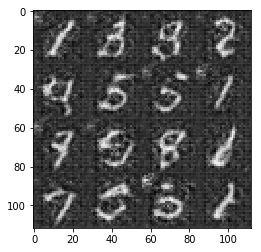

Epoch 1/2... Avg. Discriminator Loss: 0.8360... Avg. Generator Loss: 1.3858


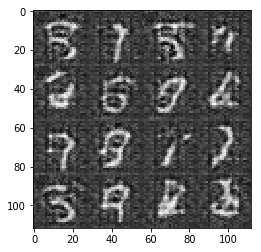

Epoch 1/2... Avg. Discriminator Loss: 0.9120... Avg. Generator Loss: 1.6819


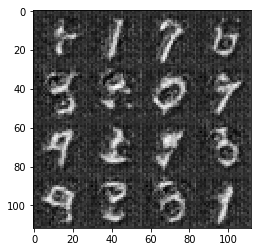

Epoch 1/2... Avg. Discriminator Loss: 0.9551... Avg. Generator Loss: 2.6007


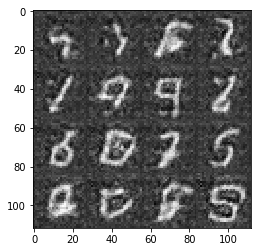

Epoch 1/2... Avg. Discriminator Loss: 1.1541... Avg. Generator Loss: 1.3839


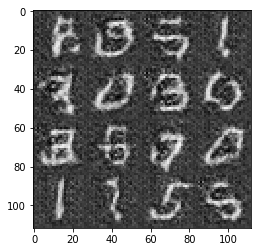

Epoch 1/2... Avg. Discriminator Loss: 0.9348... Avg. Generator Loss: 1.3967


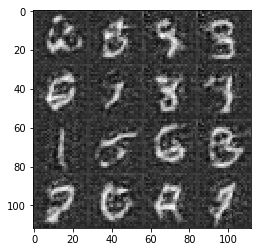

Epoch 1/2... Avg. Discriminator Loss: 0.9368... Avg. Generator Loss: 1.8982


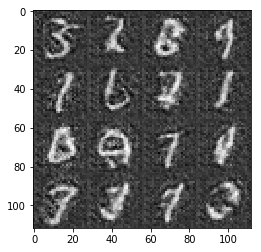

Epoch 1/2... Avg. Discriminator Loss: 0.6098... Avg. Generator Loss: 2.1894


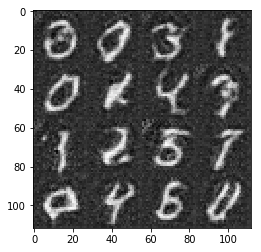

Epoch 1/2... Avg. Discriminator Loss: 1.1366... Avg. Generator Loss: 2.4106


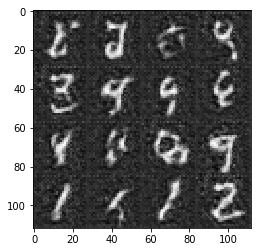

Epoch 2/2... Avg. Discriminator Loss: 0.8886... Avg. Generator Loss: 2.5751


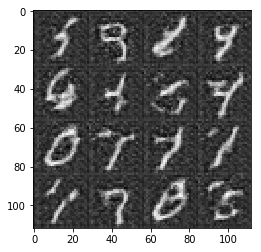

Epoch 2/2... Avg. Discriminator Loss: 0.8401... Avg. Generator Loss: 1.6187


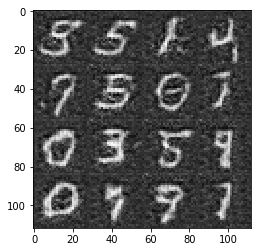

Epoch 2/2... Avg. Discriminator Loss: 0.8799... Avg. Generator Loss: 1.6690


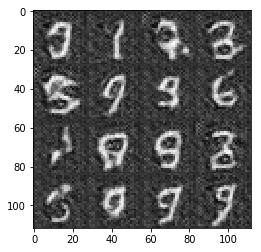

Epoch 2/2... Avg. Discriminator Loss: 0.6639... Avg. Generator Loss: 2.1246


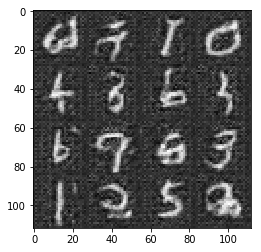

Epoch 2/2... Avg. Discriminator Loss: 0.6872... Avg. Generator Loss: 2.0680


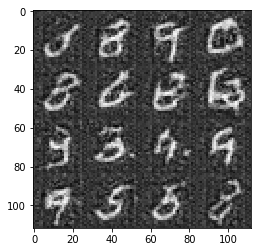

Epoch 2/2... Avg. Discriminator Loss: 0.4860... Avg. Generator Loss: 2.9711


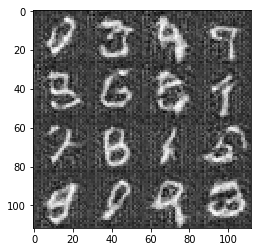

Epoch 2/2... Avg. Discriminator Loss: 0.7509... Avg. Generator Loss: 3.1485


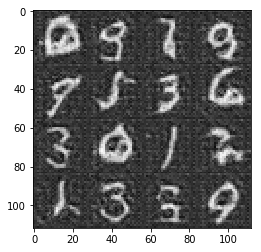

Epoch 2/2... Avg. Discriminator Loss: 0.9549... Avg. Generator Loss: 1.8458


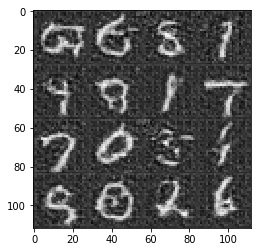

Epoch 2/2... Avg. Discriminator Loss: 0.5068... Avg. Generator Loss: 2.5303


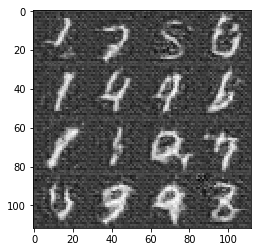

Epoch 2/2... Avg. Discriminator Loss: 1.8080... Avg. Generator Loss: 2.1885


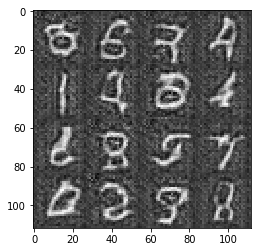

Epoch 2/2... Avg. Discriminator Loss: 0.9055... Avg. Generator Loss: 1.4172


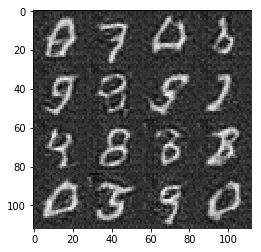

Epoch 2/2... Avg. Discriminator Loss: 1.0181... Avg. Generator Loss: 1.4038


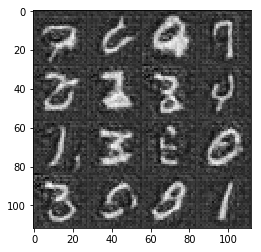

Epoch 2/2... Avg. Discriminator Loss: 1.1029... Avg. Generator Loss: 1.3971


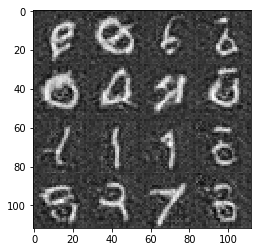

Epoch 2/2... Avg. Discriminator Loss: 1.0685... Avg. Generator Loss: 1.3491


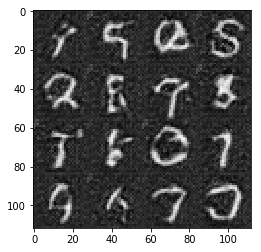

Epoch 2/2... Avg. Discriminator Loss: 1.0225... Avg. Generator Loss: 1.6701


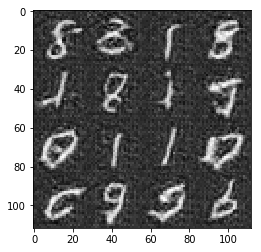

Epoch 2/2... Avg. Discriminator Loss: 0.7410... Avg. Generator Loss: 1.7192


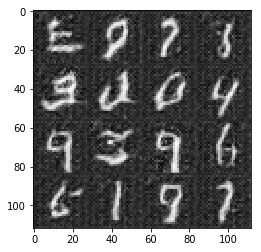

Epoch 2/2... Avg. Discriminator Loss: 1.1597... Avg. Generator Loss: 1.8372


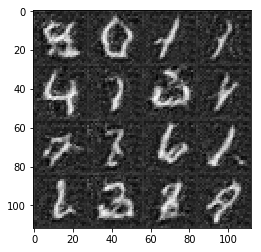

Epoch 2/2... Avg. Discriminator Loss: 0.9347... Avg. Generator Loss: 1.6563


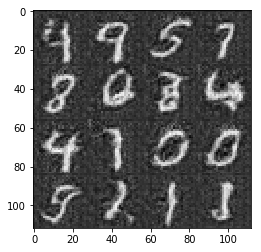

Epoch 2/2... Avg. Discriminator Loss: 1.3588... Avg. Generator Loss: 1.4385


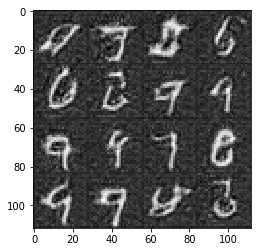

Epoch 2/2... Avg. Discriminator Loss: 0.8463... Avg. Generator Loss: 1.6272


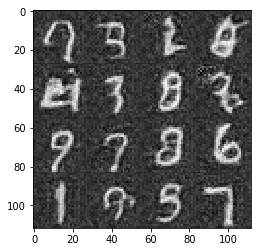

Epoch 2/2... Avg. Discriminator Loss: 1.0978... Avg. Generator Loss: 1.7345


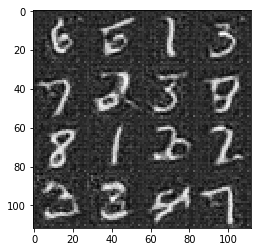

Epoch 2/2... Avg. Discriminator Loss: 1.2113... Avg. Generator Loss: 1.3021


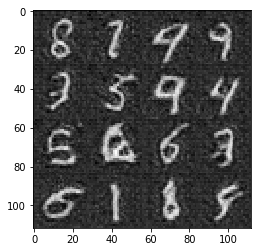

Epoch 2/2... Avg. Discriminator Loss: 1.0202... Avg. Generator Loss: 1.4465


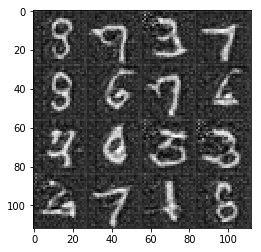

Epoch 2/2... Avg. Discriminator Loss: 0.6034... Avg. Generator Loss: 1.7590


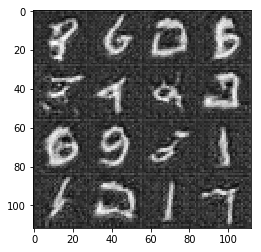

Epoch 2/2... Avg. Discriminator Loss: 1.0679... Avg. Generator Loss: 2.0562


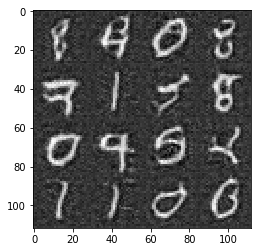

Epoch 2/2... Avg. Discriminator Loss: 1.1202... Avg. Generator Loss: 1.3462


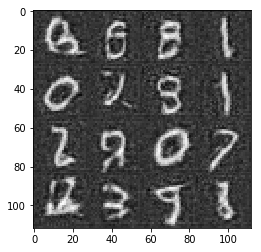

Epoch 2/2... Avg. Discriminator Loss: 0.8542... Avg. Generator Loss: 1.3826


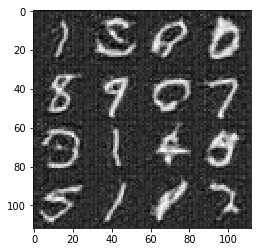

Epoch 2/2... Avg. Discriminator Loss: 1.0644... Avg. Generator Loss: 1.9579


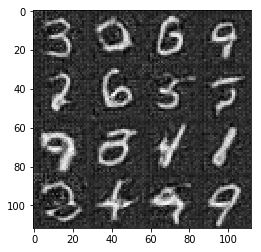

Epoch 2/2... Avg. Discriminator Loss: 1.1247... Avg. Generator Loss: 1.3051


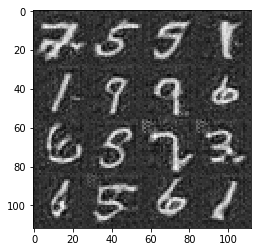

Epoch 2/2... Avg. Discriminator Loss: 0.7898... Avg. Generator Loss: 1.6610


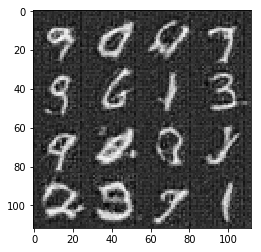

Epoch 2/2... Avg. Discriminator Loss: 0.7248... Avg. Generator Loss: 2.0221


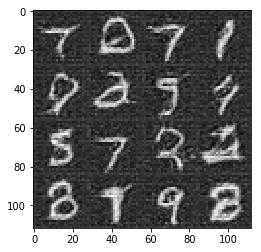

Epoch 2/2... Avg. Discriminator Loss: 0.4902... Avg. Generator Loss: 2.7939


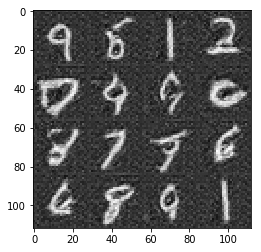

Epoch 2/2... Avg. Discriminator Loss: 0.4575... Avg. Generator Loss: 3.4422


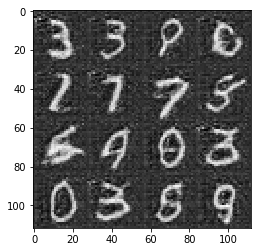

Epoch 2/2... Avg. Discriminator Loss: 0.4506... Avg. Generator Loss: 3.5631


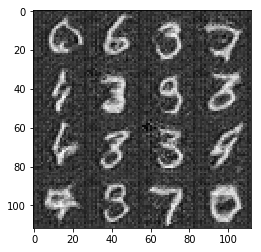

Epoch 2/2... Avg. Discriminator Loss: 1.3940... Avg. Generator Loss: 3.3009


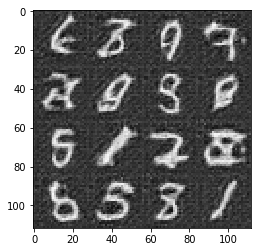

Epoch 2/2... Avg. Discriminator Loss: 0.9081... Avg. Generator Loss: 1.2633


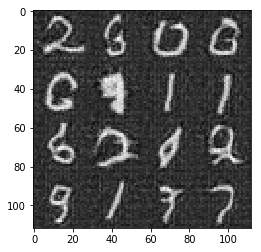

Epoch 2/2... Avg. Discriminator Loss: 1.0324... Avg. Generator Loss: 1.2713


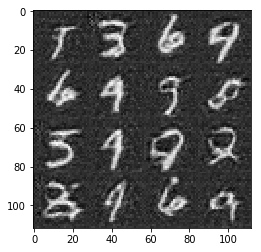

Epoch 2/2... Avg. Discriminator Loss: 1.1858... Avg. Generator Loss: 1.1860


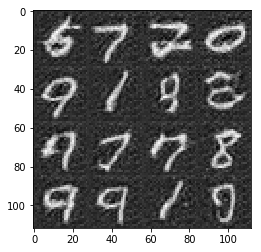

Epoch 2/2... Avg. Discriminator Loss: 1.2119... Avg. Generator Loss: 1.2010


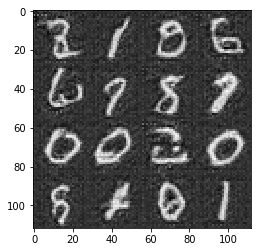

Epoch 2/2... Avg. Discriminator Loss: 1.0619... Avg. Generator Loss: 1.4792


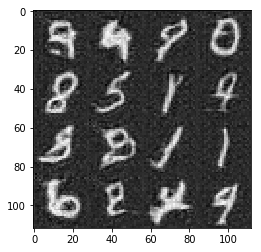

Epoch 2/2... Avg. Discriminator Loss: 0.7891... Avg. Generator Loss: 1.6888


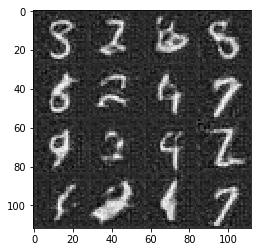

Epoch 2/2... Avg. Discriminator Loss: 0.6816... Avg. Generator Loss: 2.3764


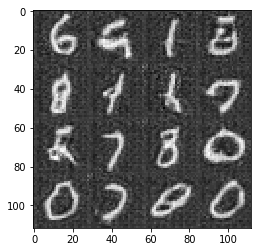

Epoch 2/2... Avg. Discriminator Loss: 1.3529... Avg. Generator Loss: 1.5620


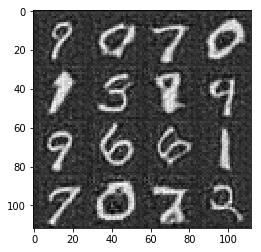

Epoch 2/2... Avg. Discriminator Loss: 0.9175... Avg. Generator Loss: 1.3180


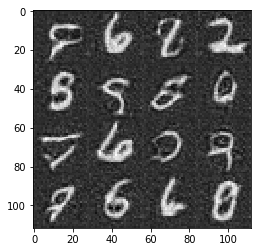

Epoch 2/2... Avg. Discriminator Loss: 0.7497... Avg. Generator Loss: 1.6162


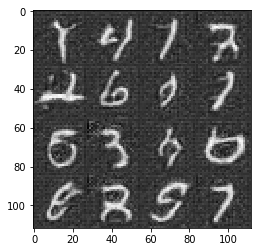

Epoch 2/2... Avg. Discriminator Loss: 1.1819... Avg. Generator Loss: 1.6290


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

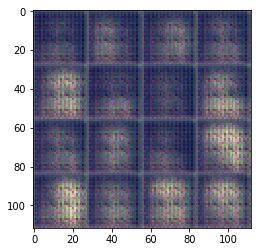

Epoch 1/1... Avg. Discriminator Loss: 2.9227... Avg. Generator Loss: 2.7488


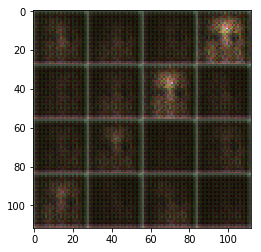

Epoch 1/1... Avg. Discriminator Loss: 0.9997... Avg. Generator Loss: 2.0173


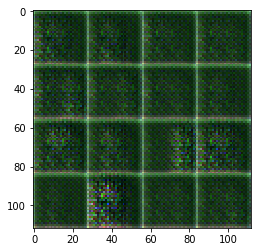

Epoch 1/1... Avg. Discriminator Loss: 1.0211... Avg. Generator Loss: 2.3794


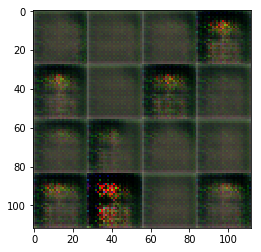

Epoch 1/1... Avg. Discriminator Loss: 0.9157... Avg. Generator Loss: 3.0156


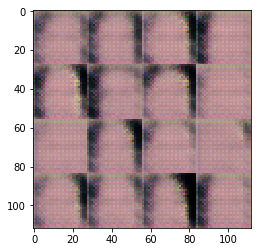

Epoch 1/1... Avg. Discriminator Loss: 1.1263... Avg. Generator Loss: 2.3282


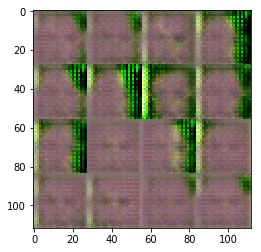

Epoch 1/1... Avg. Discriminator Loss: 0.8223... Avg. Generator Loss: 3.0106


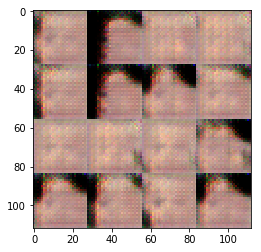

Epoch 1/1... Avg. Discriminator Loss: 0.6914... Avg. Generator Loss: 2.8234


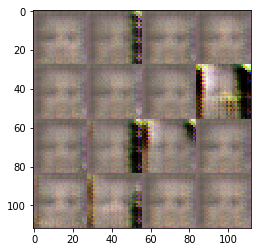

Epoch 1/1... Avg. Discriminator Loss: 0.6042... Avg. Generator Loss: 3.4402


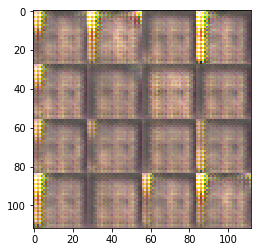

Epoch 1/1... Avg. Discriminator Loss: 0.9579... Avg. Generator Loss: 2.4513


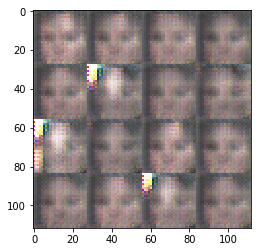

Epoch 1/1... Avg. Discriminator Loss: 0.4176... Avg. Generator Loss: 3.4109


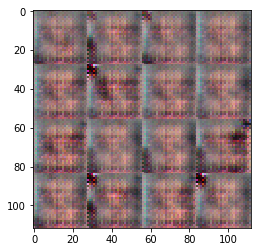

Epoch 1/1... Avg. Discriminator Loss: 1.0882... Avg. Generator Loss: 2.4204


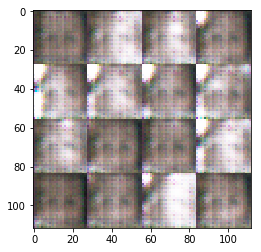

Epoch 1/1... Avg. Discriminator Loss: 1.0369... Avg. Generator Loss: 2.3820


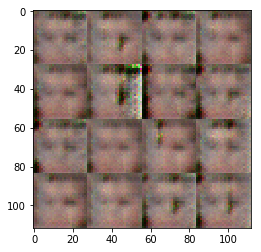

Epoch 1/1... Avg. Discriminator Loss: 0.8415... Avg. Generator Loss: 2.3106


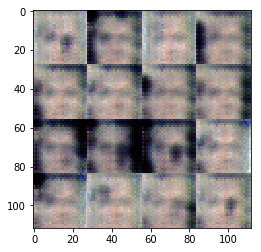

Epoch 1/1... Avg. Discriminator Loss: 1.0198... Avg. Generator Loss: 2.7550


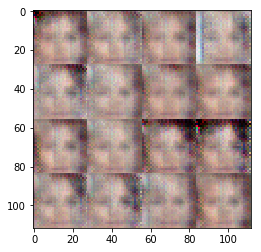

Epoch 1/1... Avg. Discriminator Loss: 0.8263... Avg. Generator Loss: 1.8165


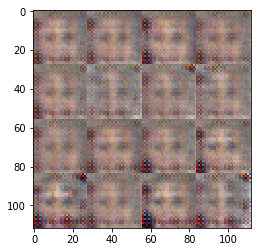

Epoch 1/1... Avg. Discriminator Loss: 0.7304... Avg. Generator Loss: 2.1486


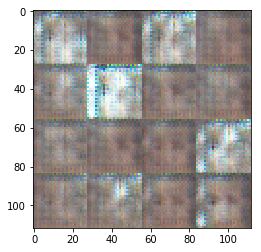

Epoch 1/1... Avg. Discriminator Loss: 0.7031... Avg. Generator Loss: 3.1598


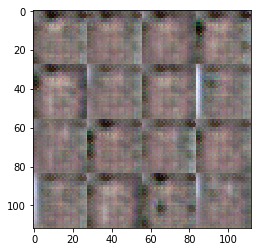

Epoch 1/1... Avg. Discriminator Loss: 0.8822... Avg. Generator Loss: 2.9843


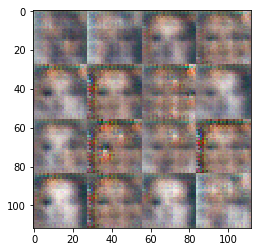

Epoch 1/1... Avg. Discriminator Loss: 1.3009... Avg. Generator Loss: 1.3309


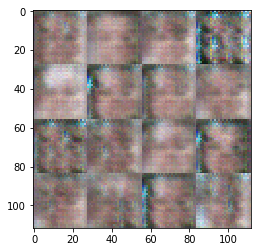

Epoch 1/1... Avg. Discriminator Loss: 1.3199... Avg. Generator Loss: 1.3238


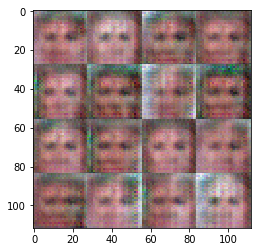

Epoch 1/1... Avg. Discriminator Loss: 1.1155... Avg. Generator Loss: 1.1495


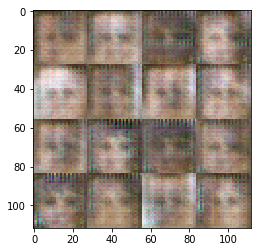

Epoch 1/1... Avg. Discriminator Loss: 1.3154... Avg. Generator Loss: 1.0868


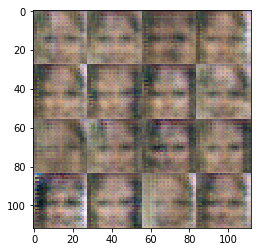

Epoch 1/1... Avg. Discriminator Loss: 1.1784... Avg. Generator Loss: 1.3525


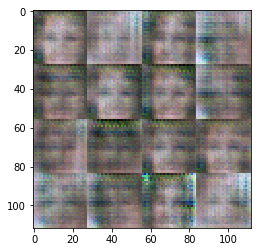

Epoch 1/1... Avg. Discriminator Loss: 1.1395... Avg. Generator Loss: 1.1829


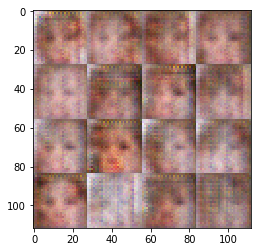

Epoch 1/1... Avg. Discriminator Loss: 1.3292... Avg. Generator Loss: 1.3869


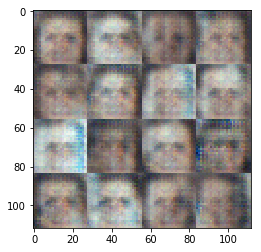

Epoch 1/1... Avg. Discriminator Loss: 1.2316... Avg. Generator Loss: 1.4028


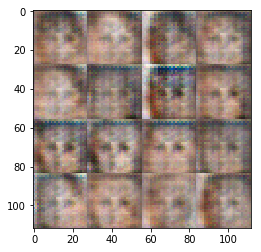

Epoch 1/1... Avg. Discriminator Loss: 0.9844... Avg. Generator Loss: 1.4201


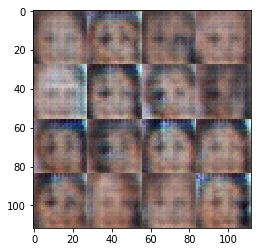

Epoch 1/1... Avg. Discriminator Loss: 1.1361... Avg. Generator Loss: 1.5034


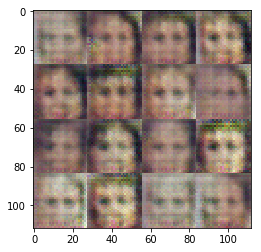

Epoch 1/1... Avg. Discriminator Loss: 1.2371... Avg. Generator Loss: 1.6779


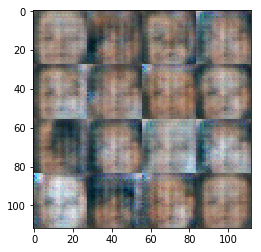

Epoch 1/1... Avg. Discriminator Loss: 0.9986... Avg. Generator Loss: 1.4302


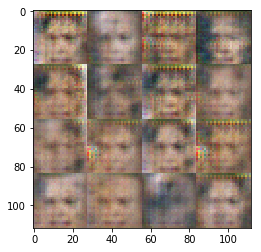

Epoch 1/1... Avg. Discriminator Loss: 1.0874... Avg. Generator Loss: 1.8108


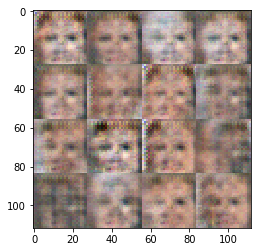

Epoch 1/1... Avg. Discriminator Loss: 1.0338... Avg. Generator Loss: 1.6581


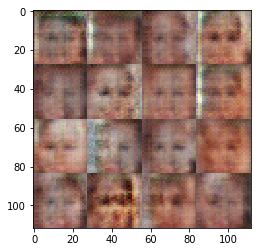

Epoch 1/1... Avg. Discriminator Loss: 1.0374... Avg. Generator Loss: 1.6587


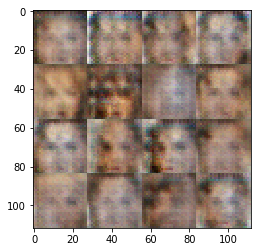

Epoch 1/1... Avg. Discriminator Loss: 1.1079... Avg. Generator Loss: 1.6540


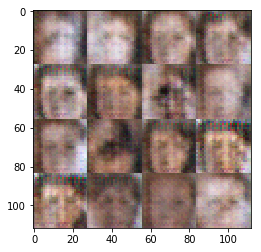

Epoch 1/1... Avg. Discriminator Loss: 1.1218... Avg. Generator Loss: 1.4417


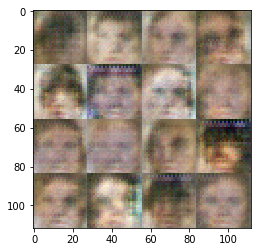

Epoch 1/1... Avg. Discriminator Loss: 1.0331... Avg. Generator Loss: 1.5165


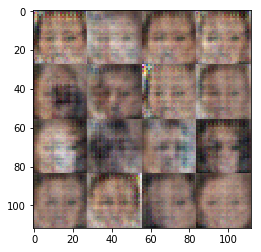

Epoch 1/1... Avg. Discriminator Loss: 1.1522... Avg. Generator Loss: 1.6791


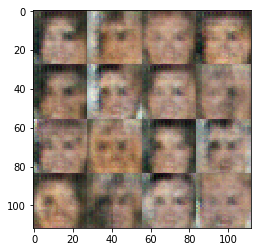

Epoch 1/1... Avg. Discriminator Loss: 1.1248... Avg. Generator Loss: 1.6628


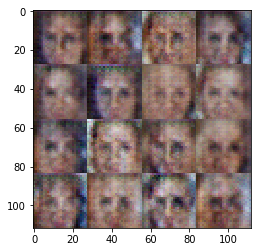

Epoch 1/1... Avg. Discriminator Loss: 1.0399... Avg. Generator Loss: 1.6317


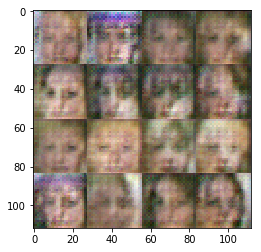

Epoch 1/1... Avg. Discriminator Loss: 1.0720... Avg. Generator Loss: 1.6562


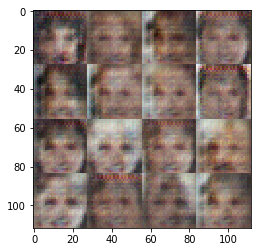

Epoch 1/1... Avg. Discriminator Loss: 1.1933... Avg. Generator Loss: 1.9868


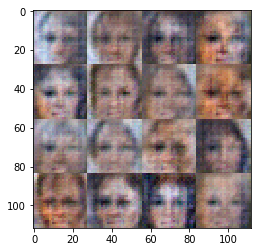

Epoch 1/1... Avg. Discriminator Loss: 1.0483... Avg. Generator Loss: 1.6522


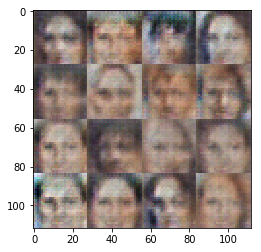

Epoch 1/1... Avg. Discriminator Loss: 0.9996... Avg. Generator Loss: 1.6697


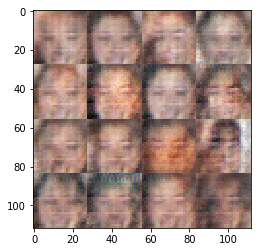

Epoch 1/1... Avg. Discriminator Loss: 1.1372... Avg. Generator Loss: 1.6210


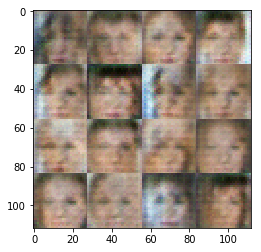

Epoch 1/1... Avg. Discriminator Loss: 1.0549... Avg. Generator Loss: 1.8480


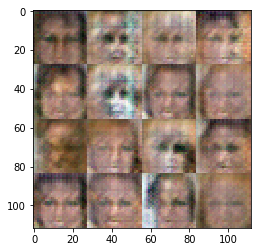

Epoch 1/1... Avg. Discriminator Loss: 0.9853... Avg. Generator Loss: 1.9168


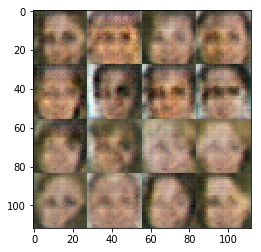

Epoch 1/1... Avg. Discriminator Loss: 1.1573... Avg. Generator Loss: 1.8525


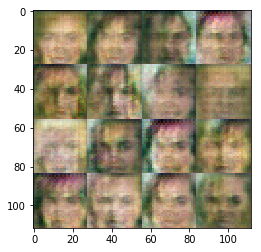

Epoch 1/1... Avg. Discriminator Loss: 0.9744... Avg. Generator Loss: 1.2924


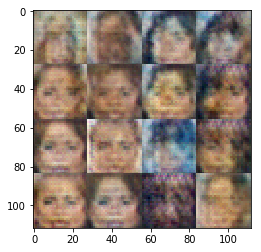

Epoch 1/1... Avg. Discriminator Loss: 1.0294... Avg. Generator Loss: 1.7146


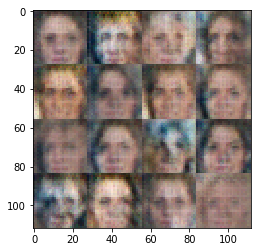

Epoch 1/1... Avg. Discriminator Loss: 1.0784... Avg. Generator Loss: 1.8747


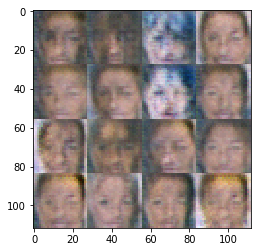

Epoch 1/1... Avg. Discriminator Loss: 1.0250... Avg. Generator Loss: 1.5836


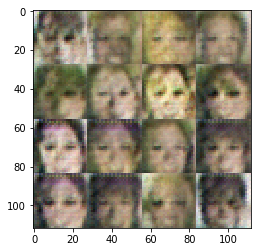

Epoch 1/1... Avg. Discriminator Loss: 1.0439... Avg. Generator Loss: 1.7333


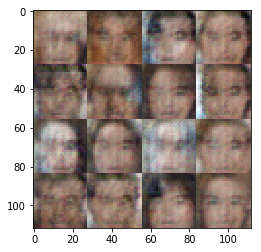

Epoch 1/1... Avg. Discriminator Loss: 0.9127... Avg. Generator Loss: 1.9583


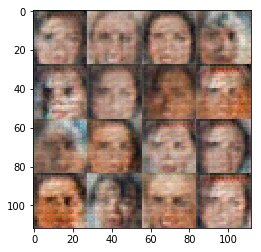

Epoch 1/1... Avg. Discriminator Loss: 1.0136... Avg. Generator Loss: 1.6632


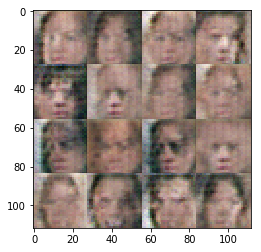

Epoch 1/1... Avg. Discriminator Loss: 1.0338... Avg. Generator Loss: 1.6508


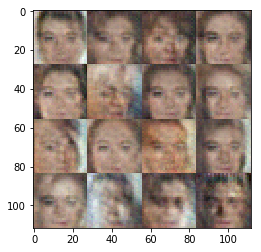

Epoch 1/1... Avg. Discriminator Loss: 1.0366... Avg. Generator Loss: 1.9887


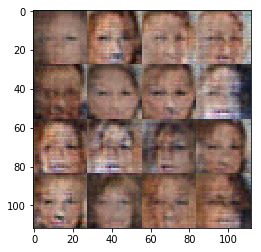

Epoch 1/1... Avg. Discriminator Loss: 1.0084... Avg. Generator Loss: 1.5841


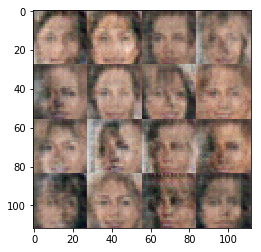

Epoch 1/1... Avg. Discriminator Loss: 0.9826... Avg. Generator Loss: 1.6789


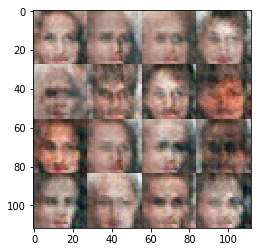

Epoch 1/1... Avg. Discriminator Loss: 0.9226... Avg. Generator Loss: 1.6751


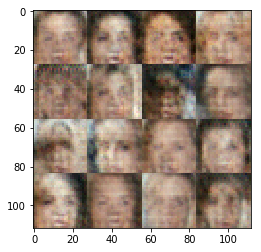

Epoch 1/1... Avg. Discriminator Loss: 1.0969... Avg. Generator Loss: 1.9635


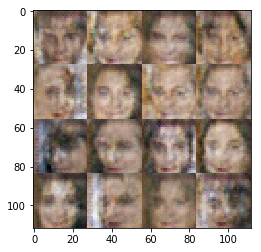

Epoch 1/1... Avg. Discriminator Loss: 0.9795... Avg. Generator Loss: 1.5059


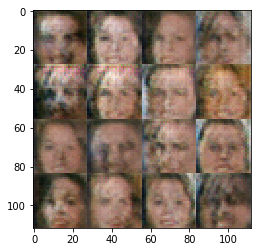

Epoch 1/1... Avg. Discriminator Loss: 1.0108... Avg. Generator Loss: 1.6308


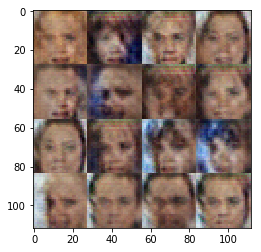

Epoch 1/1... Avg. Discriminator Loss: 1.0165... Avg. Generator Loss: 1.4109


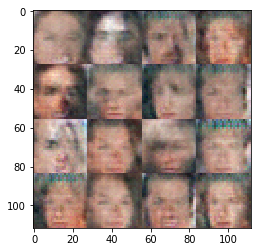

Epoch 1/1... Avg. Discriminator Loss: 1.1535... Avg. Generator Loss: 1.7350


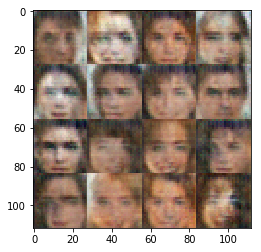

Epoch 1/1... Avg. Discriminator Loss: 0.9779... Avg. Generator Loss: 1.6271


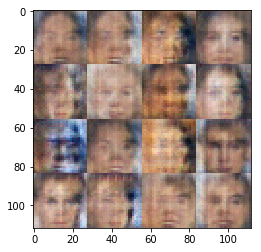

Epoch 1/1... Avg. Discriminator Loss: 0.9861... Avg. Generator Loss: 1.4384


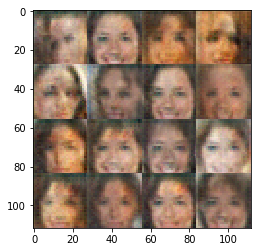

Epoch 1/1... Avg. Discriminator Loss: 1.0325... Avg. Generator Loss: 1.6836


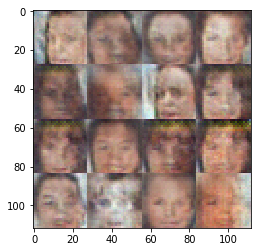

Epoch 1/1... Avg. Discriminator Loss: 1.0464... Avg. Generator Loss: 1.7734


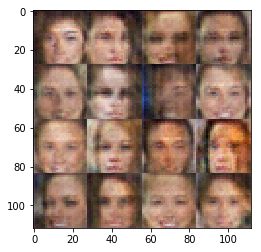

Epoch 1/1... Avg. Discriminator Loss: 1.0030... Avg. Generator Loss: 1.3869


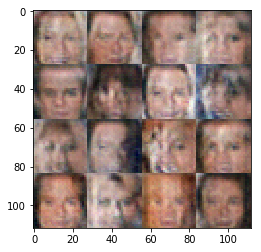

Epoch 1/1... Avg. Discriminator Loss: 1.0186... Avg. Generator Loss: 1.6951


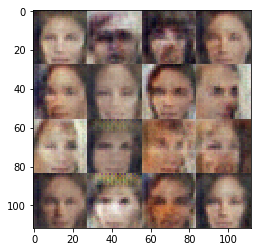

Epoch 1/1... Avg. Discriminator Loss: 1.0166... Avg. Generator Loss: 1.5118


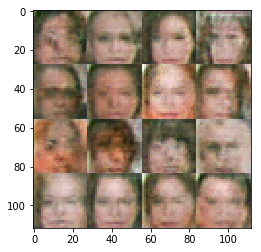

Epoch 1/1... Avg. Discriminator Loss: 1.0884... Avg. Generator Loss: 1.4362


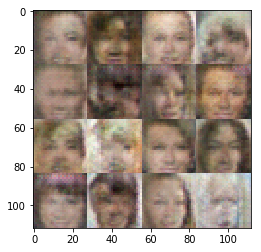

Epoch 1/1... Avg. Discriminator Loss: 0.9650... Avg. Generator Loss: 1.7696


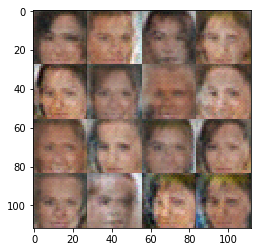

Epoch 1/1... Avg. Discriminator Loss: 1.0168... Avg. Generator Loss: 1.4990


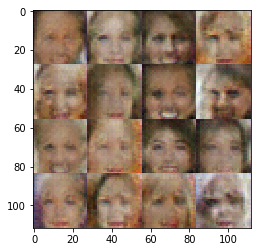

Epoch 1/1... Avg. Discriminator Loss: 0.9083... Avg. Generator Loss: 1.5021


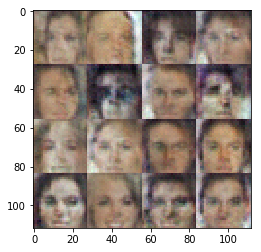

Epoch 1/1... Avg. Discriminator Loss: 1.0689... Avg. Generator Loss: 1.7191


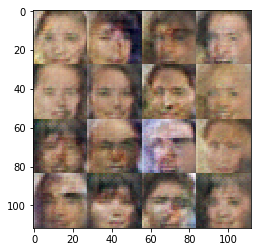

Epoch 1/1... Avg. Discriminator Loss: 1.1520... Avg. Generator Loss: 1.4356


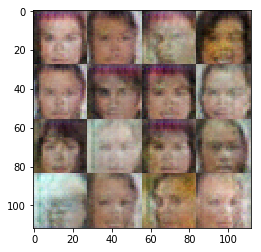

Epoch 1/1... Avg. Discriminator Loss: 1.0664... Avg. Generator Loss: 1.5245


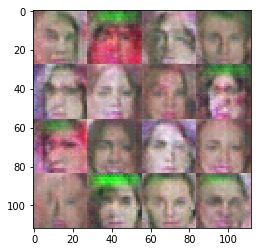

Epoch 1/1... Avg. Discriminator Loss: 0.9097... Avg. Generator Loss: 1.4227


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.